 This notebook uses a vanilla (basic) Bayesian optimization algorithm to tackle an urban travel demand (i.e.,  origin-destination, OD) calibration problem. The traffic simulations are based on the SUMO simulator. It considers a toy network, called quickstart detailed here:
 https://sumo.dlr.de/docs/Tutorials/quick_start.html

# Install sumo

Mount GDrive

If you are working w/ colab rather than a jupyterlab notebook this drive mounting and sumo installation will need to be done every time you restart the runtime.


In [1]:
import os
from pathlib import Path 
import sys

Install SUMO

In [2]:
os.environ['SUMO_HOME'] = '/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'
os.environ['LIBSUMO_AS_TRACI'] = '1' #Optional: for a huge performance boost (~8x) with Libsumo (No GUI)
SUMO_HOME = Path(os.environ['SUMO_HOME'])

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
#import traci

In [3]:
import json, shutil
from pathlib import Path

import traci
import sumolib


# Add the SUMO *bin* directory to PATH so od2trips/duarouter/sumo are found
# Your SUMO_HOME is .../EclipseSUMO/share/sumo → bin is two levels up, then /bin
SUMO_ROOT = Path(os.environ["SUMO_HOME"]).parents[1]          # .../EclipseSUMO
SUMO_BIN  = str(SUMO_ROOT / "bin") # this convert path to /EclipseSUMO/bin


os.environ["PATH"] = SUMO_BIN + os.pathsep + os.environ.get("PATH", "")



/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo/tools/traci/__init__.py:42: UserWarning: Could not import libsumo using /Users/inesbenhamza/Desktop/Sumo_od_calibration/env/bin/python, falling back to pure python traci (No module named 'libsumo').
  warnings.warn("Could not import libsumo using %s, falling back to pure python traci (%s)." %


# Macros / utils

In [5]:
# install missing packages
!pip install gpytorch
!pip install botorch
!pip install matplotlib
!pip install pandas
!pip install seaborn 

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/bin/pip: line 2: /Users/inesbenhamza/Desktop/Sumo_od_calibration 3/env/bin/python: No such file or directory
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/bin/pip: line 2: exec: /Users/inesbenhamza/Desktop/Sumo_od_calibration 3/env/bin/python: cannot execute: No such file or directory
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/bin/pip: line 2: /Users/inesbenhamza/Desktop/Sumo_od_calibration 3/env/bin/python: No such file or directory
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/bin/pip: line 2: exec: /Users/inesbenhamza/Desktop/Sumo_od_calibration 3/env/bin/python: cannot execute: No such file or directory
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/bin/pip: line 2: /Users/inesbenhamza/Desktop/Sumo_od_calibration 3/env/bin/python: No such file or directory
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/bin/pip: line 2: exec: /Users/inesbenhamza/Desktop/Sumo_od_calibration 3/env/bin/python: cannot exe

In [4]:
import os
print (os.getcwd())


/Users/inesbenhamza/Desktop/Sumo_od_calibration


In [5]:
base_path = '/Users/inesbenhamza/Desktop/Sumo_od_calibration'
# if base_path has a space in it, the sumo code will not work
if ' ' in base_path:
    raise ValueError("base_path should not contain any spaces.")

os.chdir(base_path)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import seaborn as sns
from pathlib import Path

import torch
from torch.quasirandom import SobolEngine

from botorch import fit_gpytorch_mll
from botorch.acquisition import qLogExpectedImprovement
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize, normalize

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood


# make sure the helpers_od_calibration is in your current working directory on GDrive
from helpers_od_calibration import (load_kwargs_config,
                    compute_nrmse_counts_all_edges,
                    parse_loop_data_xml_to_pandas,
                    create_taz_xml,
                    simulate_od,
                    od_xml_to_df,
                    )

%matplotlib inline

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create GT (ground truth) scenario

In [9]:
config = load_kwargs_config(base_path, "bo_vanilla")
Path(config["simulation_run_path"]).mkdir(parents=True, exist_ok=True)
pprint.pprint(dict(config))

{'BATCH_SIZE': 1,
 'EDGE_OUT_STR': 'edge_data_quickstart.xml',
 'NITER': 10,
 'NUM_RESTARTS': 5,
 'RAW_SAMPLES': 32,
 'SAMPLE_SHAPE': 128,
 'SUMO_PATH': PosixPath('/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'),
 'TRIPS2ODS_OUT_STR': 'trips.xml',
 'additional_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml'),
 'file_gt_od': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/od.xml'),
 'fixed_routes': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/routes.csv'),
 'model_name': 'bo_vanilla',
 'n_init_search': 5,
 'net_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml'),
 'network_name': 'quickstart',
 'network_path': PosixPath('network/quickstart'),
 'od_duration_sec': 300,
 'sim_end_time': 57600,
 'sim_start_time': 54000,
 'sim_stat_freq_sec': 300,
 'simulation_run_path': 'output/quickstart_bo_vanilla',


In [10]:
# Get Ground Truth OD + fixed routes
print(f"Reading: {config['file_gt_od']}")
gt_od_df = od_xml_to_df(config["file_gt_od"]) #Ground Truth OD 

print(f"Reading: {config['fixed_routes']}")
routes_df = pd.read_csv(config["fixed_routes"], index_col=0) #Fixed routes

Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/od.xml
total GT demand:  2800.0
Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/routes.csv


Simulate the GT scenario to obtain the GT traffic statistics

In [11]:
#not installed in virtual env 
import sys
!{sys.executable} -m pip install lxml


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [12]:
import sys
print(f"Python executable: {sys.executable}")

try:
    import lxml
    print(f"lxml version: {lxml.__version__}")
    print("lxml is available!")
except ImportError:
    print("lxml not found in this environment")

Python executable: /Users/inesbenhamza/Desktop/Sumo_od_calibration/env/bin/python
lxml version: 6.0.2
lxml is available!


In [13]:
simulation_gt_run_path =f'{config["simulation_run_path"]}/ground_truth'
prefix_output_gt = f'{simulation_gt_run_path}/sim'
sim_edge_out_gt = f'{prefix_output_gt}_{config["EDGE_OUT_STR"]}'
new_od_xml = f'{simulation_gt_run_path}/od.xml'
print(simulation_gt_run_path)

Path(simulation_gt_run_path).mkdir(parents=True, exist_ok=True)

output/quickstart_bo_vanilla/ground_truth


In [14]:

base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()
curr_od = gt_od_vals.copy()
base_od['count'] = curr_od
base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

print(base_od)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/ground_truth/od.xml
    from     to  count  data
0  taz91  taz93  500.0  None
1  taz91  taz94  500.0  None
2  taz92  taz93  900.0  None
3  taz92  taz94  900.0  None


In [15]:
# Run simulation to produce the traffic on eachlink given the ground trutch demand for each od pair 
simulate_od(new_od_xml,
            prefix_output_gt,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"])

od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/ground_truth/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/ground_truth/sim_trips_beforeRteUpdates.xml
Success.time 299.17
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/ground_truth/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/ground_truth/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' 

Read and process the GT simulation outputs

In [16]:
# Add debug prints before calling the function
print(f"base_path: {base_path}")
print(f"sim_edge_out_gt: {sim_edge_out_gt}")
print(f"prefix_output_gt: {prefix_output_gt}")
print(f"SUMO_PATH: {config['SUMO_PATH']}")

# Check if the XML file exists
import os
print(f"\nXML file exists: {os.path.exists(sim_edge_out_gt)}")

base_path: /Users/inesbenhamza/Desktop/Sumo_od_calibration
sim_edge_out_gt: output/quickstart_bo_vanilla/ground_truth/sim_edge_data_quickstart.xml
prefix_output_gt: output/quickstart_bo_vanilla/ground_truth/sim
SUMO_PATH: /Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo

XML file exists: True


In [17]:
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out_gt, prefix_output_gt, config["SUMO_PATH"])
# picking at edges as GT edges
num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)
gt_edge_data = df_edge_gt\
    .sort_values(by=['interval_nVehContrib'], ascending=False)\
    .iloc[:num_gt_edges]

print(sim_edge_out_gt)

Number of GT edges: 14
output/quickstart_bo_vanilla/ground_truth/sim_edge_data_quickstart.xml


# Optimization

Vanilla Bayesian Optimization (BO)


Bayesian optimization utils / helpers

in the following we are fitting the gp on all link at the same time menaing we compute one single RMSE across all links/edges as the objective

Input to GP: OD matrix [500, 500, 900, 900] (4 values)
Output from GP: Single RMSE aggregating errors across all edges (1 value)
The GP learns which OD configurations produce lower overall RMSE
Not fitting edges separately - one global objective summarizing the entire network's calibration quality!

In [93]:
def initialize_gp_model(train_X,train_Y):

    dim = train_X.size(dim=1)

    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(
            nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
        )
    )

    gp_model = SingleTaskGP(
        train_X, train_Y,
        covar_module=covar_module, likelihood=likelihood,
        outcome_transform=Standardize(m=1)
    )

    gp_mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)

    return gp_model, gp_mll

def optimize_acqf_and_get_observation(acq_func, bounds, device, dtype, BATCH_SIZE, NUM_RESTARTS, RAW_SAMPLES):
    """Optimizes the acquisition function, and returns a new candidate."""

    dim = acq_func.model.train_inputs[0].size(dim=1)

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values
    new_x = candidates.detach()

    return unnormalize(new_x, bounds)

## implementation of mogp (fitting ) : fitting gp independently for each of the link flows (all using the OD matrix as an input), and concatenate them as a list Inspect link-level GP fitting result

In [18]:

from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import Interval
from botorch.models.transforms.outcome import Standardize
import torch

In [19]:

def initialize_independent_gp_models(train_X, train_Y_multi):
    """
    Fit independent GPs for each edge/link output.
    
    Args:
        train_X: (n_observations, n_od_pairs) - OD configurations
        train_Y_multi: (n_observations, n_edges) - Traffic counts for each edge
    
    Returns:
        gp_models: List of GP models, one per edge
        mlls: List of marginal log likelihoods
    """
    n_edges = train_Y_multi.size(1)
    dim = train_X.size(1)
    
    gp_models = []
    mlls = []
    
    for edge_idx in range(n_edges):
        # Extract outputs for this specific edge
        train_Y_edge = train_Y_multi[:, edge_idx].unsqueeze(-1)  # (n_obs, 1)
        #is ran SUMO 5 times with different OD matrices then we get different train_Y_edge for each edge
        #Each observation = one SUMO simulation run with a specific OD matrix

        
        # Initialize GP for this edge
        likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
        covar_module = ScaleKernel(
            MaternKernel(
                nu=2.5, 
                ard_num_dims=dim, 
                lengthscale_constraint=Interval(0.005, 4.0)
            )
        )
        
        gp_model = SingleTaskGP(
            train_X, 
            train_Y_edge,
            covar_module=covar_module, 
            likelihood=likelihood,
            outcome_transform=Standardize(m=1)
        )
        
        mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
        
        gp_models.append(gp_model)
        mlls.append(mll)
    
    return gp_models, mlls

def predict_independent_gps(gp_models, test_X):
    """
    Make predictions using independent GPs.
    
    Args:
        gp_models: List of fitted GP models
        test_X: (n_test, n_od_pairs) - Test OD configurations
    
    Returns:
        predictions: (n_test, n_edges) - Predicted edge counts
        uncertainties: (n_test, n_edges) - Prediction uncertainties
    """
    predictions = [] # to store each link predicttion at train_X
    uncertainties = [] # same for uncertainties 
    
    for gp_model in gp_models:
        gp_model.eval()
        with torch.no_grad():
            posterior = gp_model.posterior(test_X)  # where we want the pred 
            mean = posterior.mean
            variance = posterior.variance
        
        predictions.append(mean)
        uncertainties.append(variance.sqrt())
    
    # Concatenate predictions for all edges
    predictions = torch.cat(predictions, dim=-1)  # (n_test, n_edges)
    uncertainties = torch.cat(uncertainties, dim=-1)  # (n_test, n_edges)
    
    return predictions, uncertainties

## proposed acq 

In [20]:
import torch
from torch.distributions import Normal
from botorch.acquisition import AcquisitionFunction
from typing import List

class WeightedScalarizedEI(AcquisitionFunction):
    """
    Weighted Scalarized Expected Improvement for independent multi-output GPs.
    
    Based on ParEGO scalarization approach where each edge has an independent GP
    and we maximize EI on a weighted linear combination.
    """
    
    def __init__(self, gp_models: List, weights: torch.Tensor, maximize: bool = True):
        """
        Args:
            gp_models: List of independent GP models (one per edge)
            weights: (n_edges,) tensor of scalarization weights (should sum to 1)
            maximize: If True, maximize the scalarized objective (for negative NRMSE)
        """
        super().__init__(model=gp_models[0])  # Dummy for parent class
        self.gp_models = gp_models
        self.weights = weights / weights.sum()  # Normalize to sum to 1
        self.maximize = maximize
        self.best_f = None
        
    def set_best_f(self, train_X: torch.Tensor):
        """
        Compute f* = max observed scalarized value.
        
        Args:
            train_X: (n_obs, dim) training inputs
        """
        with torch.no_grad():
            # Get predictions from all GPs at training points
            scalarized_values = self._compute_scalarized_mean(train_X)
            
            if self.maximize:
                self.best_f = scalarized_values.max().item()
            else:
                self.best_f = scalarized_values.min().item()
    
    def _compute_scalarized_mean(self, X: torch.Tensor) -> torch.Tensor:
        """
        Compute μ_s(x) = Σ w_e μ_e(x)
        
        Args:
            X: (n_points, dim) input points
            
        Returns:
            (n_points,) scalarized means
        """
        scalarized_mean = torch.zeros(X.shape[0], device=X.device, dtype=X.dtype)
        
        for i, gp_model in enumerate(self.gp_models):
            gp_model.eval()
            posterior = gp_model.posterior(X)
            mean_e = posterior.mean.squeeze(-1)  # (n_points,)
            scalarized_mean += self.weights[i] * mean_e
        
        return scalarized_mean
    
    def _compute_scalarized_variance(self, X: torch.Tensor) -> torch.Tensor:
        """
        Compute σ²_s(x) = Σ w_e² σ²_e(x)
        
        Args:
            X: (n_points, dim) input points
            
        Returns:
            (n_points,) scalarized variances
        """
        scalarized_var = torch.zeros(X.shape[0], device=X.device, dtype=X.dtype)
        
        for i, gp_model in enumerate(self.gp_models):
            gp_model.eval()
            posterior = gp_model.posterior(X)
            var_e = posterior.variance.squeeze(-1)  # (n_points,)
            scalarized_var += (self.weights[i] ** 2) * var_e
        
        return scalarized_var
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Compute EI(x) = (μ_s - f*) Φ(z) + σ_s φ(z)
        
        Args:
            X: (batch_size, n_points, dim) or (n_points, dim)
            
        Returns:
            (batch_size, n_points) or (n_points,) EI values
        """
        # Handle batched input
        original_shape = X.shape
        if X.ndim == 3:
            X = X.squeeze(0)  # (n_points, dim)
        
        # Compute scalarized posterior
        mu_s = self._compute_scalarized_mean(X)  # (n_points,)
        sigma_s = torch.sqrt(self._compute_scalarized_variance(X))  # (n_points,)
        
        # Handle maximize vs minimize
        if self.maximize:
            improvement = mu_s - self.best_f
        else:
            improvement = self.best_f - mu_s
        
        # Compute z-score
        z = improvement / (sigma_s + 1e-10)  # Add small value to avoid division by zero
        
        # Standard normal distribution
        normal = Normal(torch.zeros_like(z), torch.ones_like(z))
        
        # EI formula: (μ - f*) Φ(z) + σ φ(z)
        ei = improvement * normal.cdf(z) + sigma_s * torch.exp(normal.log_prob(z))
        
        # Restore original shape if needed
        if len(original_shape) == 3:
            ei = ei.unsqueeze(0)
        
        return ei

Declare parameter space


In [23]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

dtype =  torch.float32 

dim_od = gt_od_df.shape[0]
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype) #create a tensor [2, 4 ] filled with 0s and 2000s

# to make sure only physocally meaningful demand values are explored 
#    # Min: no vehicles and Max: 2000 vehicles per OD
#prevent suggesting unrealistic values 

print("bounds matrix:",bounds)


Using device: mps
4
bounds matrix: tensor([[   0.,    0.,    0.,    0.],
        [2000., 2000., 2000., 2000.]], device='mps:0')


## Create and simulate a sample of initial input points (i.e., ODs).

In [32]:
print (dim_od)
#4 dimension, 4OD pairs
#so we have 4 pairs so 4 demand values to optimize



4


# initial OD demand 

5 samples are used as inital training data so we will get 5 initial points training prediction 

1 observation → GP can't learn patterns
5 observations → GP can start modeling relationships
More initial samples → better initial GP, but more expensive

In [ ]:
# Sample according to Sobol, drawn are quasi random so need multiple restart !! 
# quasi bc they cover the aparameters space more evenly than pure randomness, they avoid lcuster and gaps so better coverage of space 
#it ensure we can explore differnt regions 
#better initial data, bette gp, better optimization 

sobol = SobolEngine(dim_od, scramble=True)
x_0 = sobol.draw(config["n_init_search"]).to(dtype=dtype).to(device) # generate n_init_search samples, here 5
print (x_0.shape)
#x_0 shape: torch.Size([5, 4]) meaning 5 samples of 4 dimensions each
# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)
print (train_X0)  #5 samples of 4 dimensions each

torch.Size([5, 4])
tensor([[1402.6409, 1281.0852, 1736.4589, 1159.1650],
        [ 139.6404,  231.4086,  387.2699,  528.7499],
        [ 734.8875, 1784.7427, 1339.8577, 1934.9358],
        [1970.9108,  703.8008,  533.8806,  252.7593],
        [1714.0457, 1625.1327,  151.6047,   88.0407]], device='mps:0')


## think about implementing need multiple restart 

## the following is carolina code 

In [96]:
ods_epsilon = []
loss_all = []
batch_data_i = []

# Base OD, it's entries will be updated at every epoch
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i , x in enumerate(train_X0.tolist()): # we have 5 samples so there will be 5 bo loop 
      print(f"########### OD: {i} ###########")
      print(x)

      simulation_run_path_init =f'{config["simulation_run_path"]}/initial_search'
      Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)

      new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
      prefix_output_init = f'{simulation_run_path_init}/sobol_{i}'

      # Generate OD
      #curr_od = gt_od_vals.copy()
      curr_od = np.array(x)

      print(f'total expected GT demand: {np.sum(curr_od)}')
      print(f'Total expected demand: {np.sum(curr_od):.1f} vehicles')


      ###
      # create OD xml file
      ###
      base_od['count'] = curr_od
      # round to 1 decimal point
      base_od['count'] = [round(elem, 1) for elem in base_od['count']]
      base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
      create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)
      ods_epsilon.append(curr_od)

      # simulate initial sample
      simulate_od(new_od_xml,
                  prefix_output_init,
                  base_path,
                  config["net_xml"],
                  config["taz2edge_xml"],
                  config["additional_xml"],
                  routes_df,
                  config["sim_end_time"],
                  config["TRIPS2ODS_OUT_STR"])

      ## Compute loss
      #prefix_output = f'initial_search/sobol_{i}'
      sim_edge_out = f'{base_path}/{prefix_output_init}_{config["EDGE_OUT_STR"]}'
      print(sim_edge_out)
      curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output_init,config["SUMO_PATH"])
      curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)

      loss_all.append(curr_loss)
      print(f"############## loss: {curr_loss} ##############")

      # Parse training data
      df_curr = pd.DataFrame(curr_od.reshape(1,dim_od),
                        columns = [f"x_{i+1}" for i in range(dim_od)])
      df_curr['loss'] = curr_loss
      batch_data_i.append(df_curr)

df_initial_bo = pd.concat(batch_data_i)
# Save initial dataset
df_initial_bo.to_csv(f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv",index=None)
print(f"save df_initial_bo at {config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv")

########### OD: 0 ###########
[1285.3845357894897, 645.5832123756409, 136.52652502059937, 1413.7884378433228]
total expected GT demand: 3481.2827110290527
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search/gt_od_quickstart_0.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/initial_search/gt_od_quickstart_0.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search/sobol_0_trips_beforeRteUpdates.xml
Success.time 299.26
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search/sobol_0_trips.xml -b 0 -e 57600 --additional-fi

## mine

In [35]:
# After the first parse_loop_data_xml_to_pandas call, inspect the columns
sim_edge_out = f'{base_path}/{prefix_output_init}_{config["EDGE_OUT_STR"]}'
curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
    base_path, sim_edge_out, prefix_output_init, config["SUMO_PATH"]
)

# DEBUG: Print available columns
print("Available columns in curr_loop_stats:")
print(curr_loop_stats.columns.tolist())
print("\nFirst few rows:")
print(curr_loop_stats.head(20))

Available columns in curr_loop_stats:
['edge_id', 'interval_nVehContrib', 'interval_harmonicMeanSpeed']

First few rows:
   edge_id  interval_nVehContrib  interval_harmonicMeanSpeed
0       D2                2683.0                    8.219091
1       D4                2895.0                    8.526667
2       D5                3138.0                   10.915385
3       D7                2440.0                   11.227692
4      L10                2440.0                   11.363846
5      L12                2683.0                   11.480000
6      L14                2895.0                   11.432500
7      L15                1402.0                   11.607273
8      L16                1159.0                   12.190000
9      L18                3138.0                   10.882500
10      L2                2683.0                   10.346364
11      L4                2895.0                    9.669167
12      L5                3138.0                   10.534167
13      L7               

In [45]:
# Reload the helpers module to pick up the new function
import importlib
import helpers_od_calibration
importlib.reload(helpers_od_calibration)
from helpers_od_calibration import *


In [46]:
ods_epsilon = []
loss_all = []  # Overall loss for monitoring
loss_per_edge_all = []  # Per-edge losses
batch_data_i = []
edge_counts_all = []

edge_ids = None
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()


for i, x in enumerate(train_X0.tolist()):
    print(f"\n########### OD Sample {i+1}/{config['n_init_search']} ###########")
    print(f"OD config: {x}")

    # Create output directory
    simulation_run_path_init = f'{config["simulation_run_path"]}/initial_search'
    Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)

    new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
    prefix_output_init = f'{simulation_run_path_init}/sobol_{i}'

    # Generate OD
    curr_od = np.array(x)
    print(f'Total expected demand: {np.sum(curr_od):.1f} vehicles')

    # Create OD xml file
    base_od['count'] = curr_od
    base_od['count'] = [round(elem, 1) for elem in base_od['count']]
    base_od_renamed = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
    create_taz_xml(new_od_xml, base_od_renamed, config["od_duration_sec"], base_path)
    
    ods_epsilon.append(curr_od)

    # Run SUMO simulation
    print("Running SUMO simulation...")
    simulate_od(new_od_xml,
                prefix_output_init,
                base_path,
                config["net_xml"],
                config["taz2edge_xml"],
                config["additional_xml"],
                routes_df,
                config["sim_end_time"],
                config["TRIPS2ODS_OUT_STR"])

    # Parse edge data
    sim_edge_out = f'{base_path}/{prefix_output_init}_{config["EDGE_OUT_STR"]}'
    curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
        base_path, sim_edge_out, prefix_output_init, config["SUMO_PATH"]
    )
    
    # Get edge_ids from first iteration
    if edge_ids is None:
        edge_ids = curr_loop_stats['edge_id'].tolist()
        print(f"Using {len(edge_ids)} edges: {edge_ids}")
    
    # Extract edge counts
    curr_edge_counts = curr_loop_stats.set_index('edge_id').loc[edge_ids, 'interval_nVehContrib'].values
    edge_counts_all.append(curr_edge_counts)
    
    # Compute overall loss (for monitoring)
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)
    loss_all.append(curr_loss)
    
    # Compute per-edge loss
    curr_loss_per_edge = compute_nrmse_per_edge(gt_edge_data, curr_loop_stats, edge_ids)
    loss_per_edge_all.append(curr_loss_per_edge)
    
    print(f"Overall loss (NRMSE): {curr_loss:.6f}")
    print(f"Per-edge losses - min: {curr_loss_per_edge.min():.6f}, max: {curr_loss_per_edge.max():.6f}, mean: {curr_loss_per_edge.mean():.6f}")

    # Store data
    df_curr = pd.DataFrame(curr_od.reshape(1, dim_od),
                          columns=[f"x_{i+1}" for i in range(dim_od)])
    df_curr['loss_overall'] = curr_loss
    
    # Add edge counts and per-edge losses
    for j, edge_id in enumerate(edge_ids):
        df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
        df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
    
    batch_data_i.append(df_curr)

# Save initial dataset
df_initial_bo = pd.concat(batch_data_i, ignore_index=True)
initial_csv_path = f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv"
df_initial_bo.to_csv(initial_csv_path, index=None)
print(f"\nSaved initial results to: {initial_csv_path}")



########### OD Sample 1/5 ###########
OD config: [1402.640869140625, 1281.085205078125, 1736.4588623046875, 1159.1650390625]
Total expected demand: 5579.3 vehicles
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search/gt_od_quickstart_0.xml
Running SUMO simulation...
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/initial_search/gt_od_quickstart_0.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search/sobol_0_trips_beforeRteUpdates.xml
Success.time 299.35
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search/sobol_0_tr

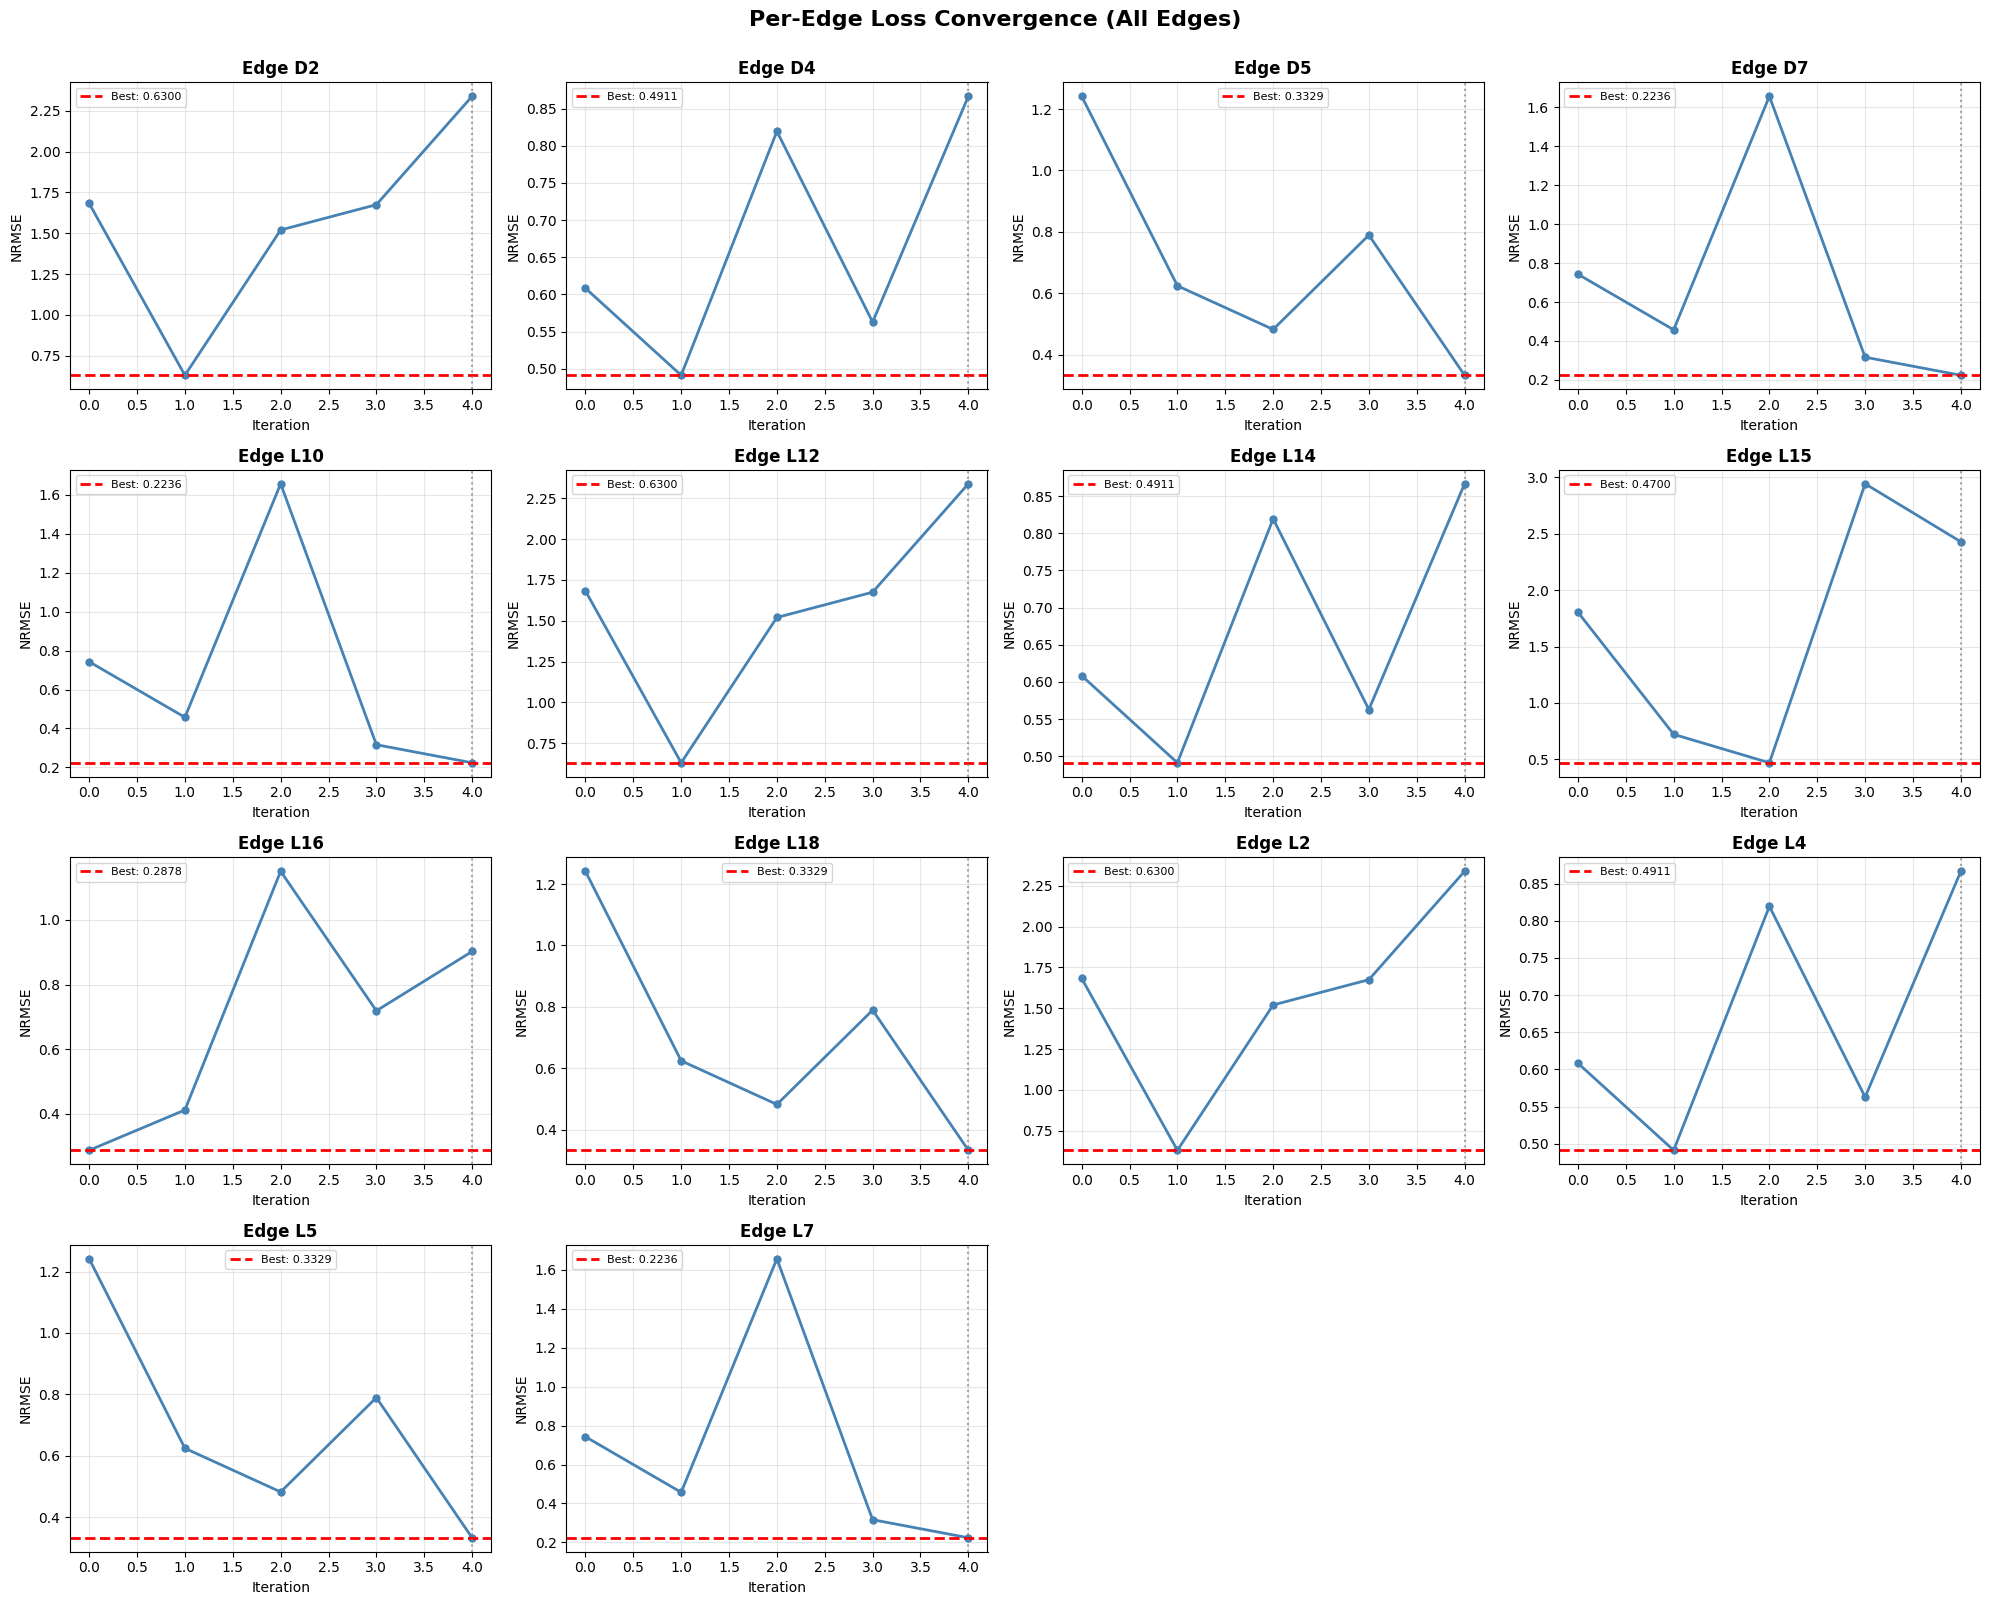

In [ ]:
n_edges = len(edge_ids)
n_cols = 4
n_rows = (n_edges + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
axes = axes.flatten()

for j, edge_id in enumerate(edge_ids):
    ax = axes[j]
    
    # Get per-edge losses over iterations
    edge_losses = [lpe[j] for lpe in loss_per_edge_all]
    
    # Plot
    ax.plot(range(len(edge_losses)), edge_losses, 'o-', linewidth=2, markersize=5, color='steelblue')
    ax.axhline(y=min(edge_losses), color='red', linestyle='--', linewidth=2, label=f'Best: {min(edge_losses):.4f}')
    ax.axvline(x=config["n_init_search"]-1, color='gray', linestyle=':', alpha=0.7)
    
    ax.set_title(f'Edge {edge_id}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Iteration', fontsize=10)
    ax.set_ylabel('NRMSE', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)


for j in range(n_edges, len(axes)):
    axes[j].axis('off')

plt.suptitle('Per-Edge Loss Convergence (All Edges)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(f"{config['simulation_run_path']}/edge_losses_all.png", dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================
# COMPUTE WEIGHTS FOR EDGES
# ============================================
print("\n" + "="*60)
print("COMPUTING EDGE WEIGHTS")
print("="*60)

# Compute weights based on ground truth flow shares
gt_edge_counts = gt_edge_data.set_index('edge_id').loc[edge_ids, 'interval_nVehContrib'].values
weights = torch.tensor(gt_edge_counts / gt_edge_counts.sum(), 
                       device=device, dtype=dtype)

print(f"\nEdge weights (based on GT flows):")
for i, edge_id in enumerate(edge_ids):
    print(f"  {edge_id:3s}: {weights[i].item():.4f} (GT count: {gt_edge_counts[i]:.1f})")


# ============================================
# SUMMARY STATISTICS - INITIAL SOBOL SAMPLING
# ============================================
print("\n" + "="*70)
print("INITIAL SOBOL SAMPLING - SUMMARY STATISTICS")
print("="*70)

# ============================================
# 1. SAMPLING OVERVIEW
# ============================================
print("\n" + "-"*70)
print("1. SAMPLING OVERVIEW")
print("-"*70)

n_samples = len(ods_epsilon)
print(f"\nNumber of Sobol samples: {n_samples}")
print(f"OD dimension: {dim_od}")
print(f"Number of edges: {len(edge_ids)}")
print(f"OD bounds: [0, 2000] vehicles per OD pair")

# ============================================
# 2. OVERALL LOSS DISTRIBUTION
# ============================================
print("\n" + "-"*70)
print("2. OVERALL NRMSE DISTRIBUTION (Across Samples)")
print("-"*70)

print(f"\n{'Statistic':<20} {'Value':<15}")
print("-"*35)
print(f"{'Mean':<20} {np.mean(loss_all):<15.6f}")
print(f"{'Median':<20} {np.median(loss_all):<15.6f}")
print(f"{'Std Dev':<20} {np.std(loss_all):<15.6f}")
print(f"{'Min':<20} {np.min(loss_all):<15.6f}")
print(f"{'Max':<20} {np.max(loss_all):<15.6f}")
print(f"{'Range':<20} {np.max(loss_all) - np.min(loss_all):<15.6f}")

best_sample_idx = np.argmin(loss_all)
worst_sample_idx = np.argmax(loss_all)

print(f"\n{'Best sample':<20} Sample {best_sample_idx} (NRMSE: {loss_all[best_sample_idx]:.6f})")
print(f"{'Worst sample':<20} Sample {worst_sample_idx} (NRMSE: {loss_all[worst_sample_idx]:.6f})")

# ============================================
# 3. OD CONFIGURATIONS SAMPLED
# ============================================
print("\n" + "-"*70)
print("3. OD CONFIGURATIONS SAMPLED")
print("-"*70)

print(f"\n{'Sample':<8} ", end='')
for i in range(dim_od):
    print(f"{'OD_' + str(i+1):<12} ", end='')
print(f"{'Total':<12} {'NRMSE':<12}")
print("-"*80)

for idx, od in enumerate(ods_epsilon):
    print(f"{idx:<8} ", end='')
    for val in od:
        print(f"{val:<12.1f} ", end='')
    print(f"{od.sum():<12.1f} {loss_all[idx]:<12.6f}")

# OD statistics across samples
print(f"\n{'OD Pair':<10} {'Mean':<12} {'Std Dev':<12} {'Min':<12} {'Max':<12} {'GT Value':<12}")
print("-"*72)

for i in range(dim_od):
    od_vals = [od[i] for od in ods_epsilon]
    print(f"{'OD_' + str(i+1):<10} {np.mean(od_vals):<12.1f} {np.std(od_vals):<12.1f} "
          f"{np.min(od_vals):<12.1f} {np.max(od_vals):<12.1f} {gt_od_vals[i]:<12.1f}")

# Total demand statistics
total_demands = [od.sum() for od in ods_epsilon]
print(f"{'Total':<10} {np.mean(total_demands):<12.1f} {np.std(total_demands):<12.1f} "
      f"{np.min(total_demands):<12.1f} {np.max(total_demands):<12.1f} {gt_od_vals.sum():<12.1f}")

# ============================================
# 4. PER-EDGE LOSS DISTRIBUTION
# ============================================
print("\n" + "-"*70)
print("4. PER-EDGE NRMSE DISTRIBUTION (Across Samples)")
print("-"*70)

print(f"\n{'Edge':<6} {'Weight':<8} {'GT Count':<10} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
print("-"*68)

for j, edge_id in enumerate(edge_ids):
    edge_losses = [lpe[j] for lpe in loss_per_edge_all]
    weight = weights[j].item()
    gt_count = gt_edge_counts[j]
    
    print(f"{edge_id:<6} {weight:<8.4f} {gt_count:<10.0f} "
          f"{np.mean(edge_losses):<10.6f} {np.std(edge_losses):<10.6f} "
          f"{np.min(edge_losses):<10.6f} {np.max(edge_losses):<10.6f}")

# ============================================
# 5. AGGREGATE EDGE STATISTICS
# ============================================
print("\n" + "-"*70)
print("5. AGGREGATE EDGE STATISTICS (Across All Samples)")
print("-"*70)

# Calculate statistics for each sample
mean_edge_losses_per_sample = [lpe.mean() for lpe in loss_per_edge_all]
median_edge_losses_per_sample = [np.median(lpe) for lpe in loss_per_edge_all]
max_edge_losses_per_sample = [lpe.max() for lpe in loss_per_edge_all]
min_edge_losses_per_sample = [lpe.min() for lpe in loss_per_edge_all]

print(f"\n{'Metric':<30} {'Mean':<12} {'Std Dev':<12} {'Min':<12} {'Max':<12}")
print("-"*78)
print(f"{'Mean edge NRMSE':<30} {np.mean(mean_edge_losses_per_sample):<12.6f} "
      f"{np.std(mean_edge_losses_per_sample):<12.6f} "
      f"{np.min(mean_edge_losses_per_sample):<12.6f} "
      f"{np.max(mean_edge_losses_per_sample):<12.6f}")

print(f"{'Median edge NRMSE':<30} {np.mean(median_edge_losses_per_sample):<12.6f} "
      f"{np.std(median_edge_losses_per_sample):<12.6f} "
      f"{np.min(median_edge_losses_per_sample):<12.6f} "
      f"{np.max(median_edge_losses_per_sample):<12.6f}")

print(f"{'Max edge NRMSE':<30} {np.mean(max_edge_losses_per_sample):<12.6f} "
      f"{np.std(max_edge_losses_per_sample):<12.6f} "
      f"{np.min(max_edge_losses_per_sample):<12.6f} "
      f"{np.max(max_edge_losses_per_sample):<12.6f}")

print(f"{'Min edge NRMSE':<30} {np.mean(min_edge_losses_per_sample):<12.6f} "
      f"{np.std(min_edge_losses_per_sample):<12.6f} "
      f"{np.min(min_edge_losses_per_sample):<12.6f} "
      f"{np.max(min_edge_losses_per_sample):<12.6f}")

# ============================================
# 6. EDGE COUNT PREDICTIONS
# ============================================
print("\n" + "-"*70)
print("6. EDGE COUNT PREDICTIONS (Across Samples)")
print("-"*70)

print(f"\n{'Edge':<6} {'GT Count':<12} {'Mean Pred':<12} {'Std Pred':<12} {'Min Pred':<12} {'Max Pred':<12}")
print("-"*72)

for j, edge_id in enumerate(edge_ids):
    edge_counts = [ec[j] for ec in edge_counts_all]
    gt_count = gt_edge_counts[j]
    
    print(f"{edge_id:<6} {gt_count:<12.0f} {np.mean(edge_counts):<12.1f} "
          f"{np.std(edge_counts):<12.1f} {np.min(edge_counts):<12.0f} "
          f"{np.max(edge_counts):<12.0f}")

# Total counts
total_gt = gt_edge_counts.sum()
total_preds = [ec.sum() for ec in edge_counts_all]
print(f"\n{'TOTAL':<6} {total_gt:<12.0f} {np.mean(total_preds):<12.1f} "
      f"{np.std(total_preds):<12.1f} {np.min(total_preds):<12.0f} "
      f"{np.max(total_preds):<12.0f}")

# ============================================
# 7. BEST SAMPLE ANALYSIS
# ============================================
print("\n" + "-"*70)
print("7. BEST SAMPLE ANALYSIS (Sample with Lowest Overall NRMSE)")
print("-"*70)

best_idx = np.argmin(loss_all)
best_od = ods_epsilon[best_idx]
best_loss = loss_all[best_idx]
best_edge_losses = loss_per_edge_all[best_idx]
best_edge_counts = edge_counts_all[best_idx]

print(f"\nBest sample: Sample {best_idx}")
print(f"Overall NRMSE: {best_loss:.6f}")
print(f"\nOD Configuration:")
print(f"{'OD Pair':<10} {'Sampled Value':<15} {'GT Value':<15} {'Absolute Error':<15} {'Relative Error (%)':<20}")
print("-"*75)

for i in range(dim_od):
    sampled = best_od[i]
    gt = gt_od_vals[i]
    abs_err = abs(sampled - gt)
    rel_err = (abs_err / gt * 100) if gt > 0 else 0
    print(f"{'OD_' + str(i+1):<10} {sampled:<15.1f} {gt:<15.1f} {abs_err:<15.1f} {rel_err:<20.2f}")

print(f"{'Total':<10} {best_od.sum():<15.1f} {gt_od_vals.sum():<15.1f} "
      f"{abs(best_od.sum() - gt_od_vals.sum()):<15.1f} "
      f"{abs(best_od.sum() - gt_od_vals.sum())/gt_od_vals.sum()*100:<20.2f}")

print(f"\nPer-Edge Performance:")
print(f"{'Edge':<6} {'GT Count':<12} {'Predicted':<12} {'NRMSE':<12} {'Abs Error':<12}")
print("-"*54)

for j, edge_id in enumerate(edge_ids):
    gt_count = gt_edge_counts[j]
    pred_count = best_edge_counts[j]
    nrmse = best_edge_losses[j]
    abs_err = abs(pred_count - gt_count)
    
    print(f"{edge_id:<6} {gt_count:<12.0f} {pred_count:<12.0f} {nrmse:<12.6f} {abs_err:<12.0f}")


# Show performance for ALL samples
print("\n" + "="*70)
print("PERFORMANCE FOR ALL SOBOL SAMPLES")
print("="*70)

for sample_idx in range(len(ods_epsilon)):
    print(f"\n{'='*70}")
    print(f"SAMPLE {sample_idx}")
    print(f"{'='*70}")
    print(f"Overall NRMSE: {loss_all[sample_idx]:.6f}")
    print(f"OD Config: {ods_epsilon[sample_idx]}")
    
    print(f"\nPer-Edge Performance:")
    print(f"{'Edge':<6} {'GT Count':<12} {'Predicted':<12} {'NRMSE':<12} {'Abs Error':<12}")
    print("-"*54)
    
    for j, edge_id in enumerate(edge_ids):
        gt_count = gt_edge_counts[j]
        pred_count = edge_counts_all[sample_idx][j]
        nrmse = loss_per_edge_all[sample_idx][j]
        abs_err = abs(pred_count - gt_count)
        
        print(f"{edge_id:<6} {gt_count:<12.0f} {pred_count:<12.0f} {nrmse:<12.6f} {abs_err:<12.0f}")
    


# ============================================
# 9. SOBOL SPACE COVERAGE
# ============================================
print("\n" + "-"*70)
print("9. SOBOL SAMPLING SPACE COVERAGE")
print("-"*70)

print(f"\nOD Space Coverage (% of [0, 2000] range):")
for i in range(dim_od):
    od_vals = [od[i] for od in ods_epsilon]
    coverage = (max(od_vals) - min(od_vals)) / 2000 * 100
    print(f"  OD_{i+1}: {coverage:.1f}% (range: {min(od_vals):.1f} - {max(od_vals):.1f})")






COMPUTING EDGE WEIGHTS

Edge weights (based on GT flows):
  D2 : 0.0549 (GT count: 1000.0)
  D4 : 0.0989 (GT count: 1800.0)
  D5 : 0.0769 (GT count: 1400.0)
  D7 : 0.0769 (GT count: 1400.0)
  L10: 0.0769 (GT count: 1400.0)
  L12: 0.0549 (GT count: 1000.0)
  L14: 0.0989 (GT count: 1800.0)
  L15: 0.0275 (GT count: 500.0)
  L16: 0.0495 (GT count: 900.0)
  L18: 0.0769 (GT count: 1400.0)
  L2 : 0.0549 (GT count: 1000.0)
  L4 : 0.0989 (GT count: 1800.0)
  L5 : 0.0769 (GT count: 1400.0)
  L7 : 0.0769 (GT count: 1400.0)

INITIAL SOBOL SAMPLING - SUMMARY STATISTICS

----------------------------------------------------------------------
1. SAMPLING OVERVIEW
----------------------------------------------------------------------

Number of Sobol samples: 5
OD dimension: 4
Number of edges: 14
OD bounds: [0, 2000] vehicles per OD pair

----------------------------------------------------------------------
2. OVERALL NRMSE DISTRIBUTION (Across Samples)
-----------------------------------------------

## Run BO epochs

the fllwoing fir the gp on all link --->single  rmse 

In [101]:
sampler = StochasticSampler(sample_shape=torch.Size([config["SAMPLE_SHAPE"]]))
df_0 = pd.read_csv(f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv")

### Run loop
best_value = []

# Data frame of current training data
df_training = df_0
df_training["bo_iteration"] = 0

df_edge_stats = pd.DataFrame()

#num_epsilon_iter = 2
ods_epsilon = []
loss_all = []
batch_data_i = []

# Base OD which we will update their count entries
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i in range(config["NITER"]):
    new_od_xml = f'{config["simulation_run_path"]}/od.xml'

    simulation_run_path_BO =f'{config["simulation_run_path"]}/BO'
    prefix_output_bo = f'{simulation_run_path_BO}/bayesOpt_{i}'
    Path(simulation_run_path_BO).mkdir(parents=True, exist_ok=True)

    ########
    # Start BO step
    ########

    print(f"########### BO iteration={i+1} ###########")

    # Obtain sampling locations x
    train_X = torch.from_numpy(
        df_training[[col for col in df_training.columns if "x" in col]].values
    ).to(device=device, dtype=dtype)

    # Normalize
    train_X_norm = normalize(train_X,bounds)

    # Obtain reponse data
    train_Y = -torch.from_numpy(df_training[["loss"]].values) # Take negative

    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    print(f"Generating new sampling location(s)....")
    # Declare model with newest data
    gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

    # Fit model
    fit_gpytorch_mll(gp_mll)

    # Construct acquistion function
    # sampler = StochasticSampler(sample_shape=torch.Size([128]))
    qEI = qLogExpectedImprovement(gp_model, best_f=best_y, sampler=sampler)

    # Maximize acquisition function to get next observation
    x_i = optimize_acqf_and_get_observation(acq_func=qEI,
                                            bounds=bounds,
                                            device=device,
                                            dtype=dtype,
                                            BATCH_SIZE=config["BATCH_SIZE"],
                                            NUM_RESTARTS=config["BATCH_SIZE"],
                                            RAW_SAMPLES=config["BATCH_SIZE"])

    # map the normalized into the original parameter space
    #x_i = unnormalize(x_i, bounds)
    x_i = x_i.cpu().detach().numpy()

    ########
    # End BO step
    ########


    # Sample simulator (inner loop across all sampling locations within a batch)
    batch_data_i = []
    for j in range(config["BATCH_SIZE"]):
        loss_all = []
        print(f"########### Sampling location={j+1} ###########")

        # Generate OD
        #curr_od = gt_od_vals.copy()
        curr_od = x_i[j]

        print(f'total expected GT demand: {np.sum(curr_od)}')

        base_od['count'] = curr_od
        # round to 1 decimal point
        base_od['count'] = [round(elem, 1) for elem in base_od['count']]
        base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
        create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

        # simulate gt od
        simulate_od(new_od_xml,
                    prefix_output_bo,
                    base_path,
                    config["net_xml"],
                    config["taz2edge_xml"],
                    config["additional_xml"],
                    routes_df,
                    config["sim_end_time"],
                    config["TRIPS2ODS_OUT_STR"])

        ## Compute loss
        sim_edge_out = f'{base_path}/{prefix_output_bo}_{config["EDGE_OUT_STR"]}'
        print(sim_edge_out)
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output_bo,config["SUMO_PATH"])

        curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)
        loss_all.append(curr_loss)
        print(f"############## loss: {curr_loss} ##############")

        # Parse training data
        df_j = pd.DataFrame(x_i[j].reshape(1,dim_od),
                            columns = [f"x_{i+1}" for i in range(dim_od)])
        df_j['loss'] = curr_loss
        batch_data_i.append(df_j)

        curr_loop_stats['bo_iteration'] = i
        curr_loop_stats['batch'] = j
        df_edge_stats = pd.concat([df_edge_stats, curr_loop_stats])

    df_i = pd.concat(batch_data_i)
    df_i["bo_iteration"] = i+1

    df_training = pd.concat([df_training,df_i])


########### BO iteration=1 ###########
##### best_value=-0.248876002422034 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 1495.1636264555566
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_0_trips_beforeRteUpdates.xml
Success.time 299.34
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_0_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Su

## RUN BO EPOCH FOR MOGP 


In [ ]:
ods_epsilon = []
loss_all = []
batch_data_i = []
edge_counts_all = []  # NEW: Store edge counts for each simulation

# Base OD, it's entries will be updated at every epoch
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i, x in enumerate(train_X0.tolist()):
    print(f"########### OD: {i} ###########")
    print(x)

    simulation_run_path_init = f'{config["simulation_run_path"]}/initial_search'
    Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)

    new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
    prefix_output_init = f'{simulation_run_path_init}/sobol_{i}'

    # Generate OD
    curr_od = np.array(x)
    print(f'total expected GT demand: {np.sum(curr_od)}')

    # Create OD xml file
    base_od['count'] = curr_od
    base_od['count'] = [round(elem, 1) for elem in base_od['count']]
    base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
    create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)
    ods_epsilon.append(curr_od)

    # Simulate initial sample
    simulate_od(new_od_xml,
                prefix_output_init,
                base_path,
                config["net_xml"],
                config["taz2edge_xml"],
                config["additional_xml"],
                routes_df,
                config["sim_end_time"],
                config["TRIPS2ODS_OUT_STR"])

    ## Parse edge data
    sim_edge_out = f'{base_path}/{prefix_output_init}_{config["EDGE_OUT_STR"]}'
    print(sim_edge_out)
    curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out, prefix_output_init, config["SUMO_PATH"])
    
    ## NEW: Extract individual edge counts for MOGP
    # Assuming edge_columns like ['interval_nVehContrib'] or specific edge IDs
    edge_columns = ['edge_D2_count', 'edge_D4_count', 'edge_D5_count', 'edge_D7_count']  # Adjust to your actual columns
    curr_edge_counts = curr_loop_stats[edge_columns].values[0]  # Get first row or aggregate
    edge_counts_all.append(curr_edge_counts)
    
    ## Compute overall loss (for comparison/logging)
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)
    loss_all.append(curr_loss)
    print(f"############## loss: {curr_loss} ##############")

    # Parse training data
    df_curr = pd.DataFrame(curr_od.reshape(1, dim_od),
                          columns=[f"x_{i+1}" for i in range(dim_od)])
    df_curr['loss'] = curr_loss
    
    # NEW: Add individual edge counts to dataframe
    for j, col in enumerate(edge_columns):
        df_curr[col] = curr_edge_counts[j]
    
    batch_data_i.append(df_curr)

# Concatenate all results
df_initial_bo = pd.concat(batch_data_i)
df_initial_bo.to_csv(f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv", index=None)
print(f"Saved df_initial_bo at {config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv")

# NEW: Prepare multi-output training data for MOGP
train_X = torch.tensor(np.array(ods_epsilon), device=device, dtype=dtype)  # (n_init, dim_od)
train_Y_multi = torch.tensor(np.array(edge_counts_all), device=device, dtype=dtype)  # (n_init, n_edges)

print(f"\nTraining data shapes:")
print(f"train_X: {train_X.shape}")  # e.g., (5, 4)
print(f"train_Y_multi: {train_Y_multi.shape}")  # e.g., (5, 4) for 4 edges

# Initialize independent GPs for each edge
gp_models, mlls = initialize_independent_gp_models(train_X, train_Y_multi)

# Fit each GP
from gpytorch.mlls import fit_gpytorch_model

for i, (gp_model, mll) in enumerate(zip(gp_models, mlls)):
    print(f"Fitting GP for edge {i+1}/{len(gp_models)}...")
    fit_gpytorch_model(mll)

print(f"\nFitted {len(gp_models)} independent GPs")

# Compute weights based on ground truth flow shares
gt_edge_counts = gt_edge_data[edge_columns].mean(axis=0).values
weights = torch.tensor(gt_edge_counts / gt_edge_counts.sum(), device=device, dtype=dtype)
print(f"Edge weights (based on GT flows): {weights}")

# Create weighted scalarized EI acquisition function
acq_func = WeightedScalarizedEI(
    gp_models=gp_models,
    weights=weights,
    maximize=False  # Minimize NRMSE (not negative NRMSE)
)

# Set best observed value
acq_func.set_best_f(train_X)
print(f"Best observed f*: {acq_func.best_f}")

MOGP --> building indepednent gp 

Log per-edge errors instead of only one global loss

Using acquisition as aggregated linear weighted sum 

In [113]:
print(gt_flow) #ground truth flows 

[1800. 1800. 1800. 1400. 1400. 1400. 1400. 1400. 1400. 1000. 1000. 1000.
  900.  500.]


In [110]:
[c for c in df_training.columns if c.startswith("y_edge_")][:20], df_training.shape

(['y_edge_0',
  'y_edge_1',
  'y_edge_2',
  'y_edge_3',
  'y_edge_4',
  'y_edge_5',
  'y_edge_6',
  'y_edge_7',
  'y_edge_8',
  'y_edge_9',
  'y_edge_10',
  'y_edge_11',
  'y_edge_12',
  'y_edge_13'],
 (15, 19))

In [111]:
import numpy as np
edge_cols = sorted([c for c in df_training.columns if c.startswith("y_edge_")],
                   key=lambda s: int(s.split("_")[-1]))
Y = df_training[edge_cols].to_numpy()         # negative per-edge errors
scalarized = (Y * w_np).sum(axis=1)           # what BO is optimizing (maximize)
# If you logged global NRMSE per row, compare; else recompute for those rows or skip.
if "global_loss" in df_training.columns:
    import pandas as pd
    corr = np.corrcoef(scalarized, -df_training["global_loss"].to_numpy())[0,1]
    print("Corr( scalarized , -global_NRMSE ) =", corr)

Store outputs

In [ ]:
print(f"saving at {config['simulation_run_path']}/BO/data_set_bayes_opt.csv")
df_training.to_csv(f"{config['simulation_run_path']}/BO/data_set_bayes_opt.csv",index=None)

print(f"saving at {config['simulation_run_path']}/BO/df_edge_stats.csv")
df_edge_stats.to_csv(f"{config['simulation_run_path']}/BO/df_edge_stats.csv",index=None)

# Results analysis

Convergence plots

In [ ]:
df_training = pd.read_csv(f"{config['simulation_run_path']}/BO/data_set_bayes_opt.csv")
df_edge_stats = pd.read_csv(f"{config['simulation_run_path']}/BO/df_edge_stats.csv")

df_plot = df_training.query('bo_iteration>0')
x = df_plot['bo_iteration']
y = df_plot['loss'].cummin()

plt.plot(x, y)
#plt.legend(title='Parameter where:')
plt.xlabel('BO epoch')
plt.ylabel('Best NRMSE')
# plt.show()
# plt.savefig(f"{config['simulation_run_path']}/bo_nrmse.png")

In [ ]:
if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

losses = []
for o1 in range(config["NITER"]): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

Scatter plots: fit to traffic data

In [ ]:
if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

Path(f"{config['simulation_run_path']}/figs").mkdir(parents=True, exist_ok=True)

losses = []
for o1 in range(config["NITER"]): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

    # find idx of min loss
    idx_min = np.argmin(losses)
    o1 = idx_min

    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)

    plt.figure()
    # plotting diagonal line that represents a perfect data fit
    max_val = np.max([df1b.interval_nVehContrib_gt.max(), df1b.interval_nVehContrib_bo.max()])
    vec = np.arange(max_val)
    plt.plot(vec, vec, 'r-')
    plt.plot(df1b.interval_nVehContrib_gt, df1b.interval_nVehContrib_bo, 'x')
    # plt.title(f'BO epochs: {o1}; loss: {curr_loss}')
    plt.xlabel('GT edge counts')
    plt.ylabel('Simulated edge counts')
    #plt.savefig(f"{config['simulation_run_path']}/figs/{o1}_bo_edge_counts.png")


    # plot of fit to GT OD vs ET OD
    plt.figure()
    # get the OD values with the best loss
    curr_od = df_training.query('bo_iteration==@o1').iloc[0][[col for col in df_training.columns if "x" in col]].values
    # bar graph side by side by x axis
    width = 0.35
    plt.bar(np.arange(len(curr_od)), curr_od, width, label='BO')
    plt.bar(np.arange(len(gt_od_vals)) + width, gt_od_vals, width, label='GT')
    plt.legend()
    plt.xlabel('OD pair')
    plt.ylabel('Demand')
    plt.title(f'BO iteration: {o1}')
    # plt.savefig(f"{config['simulation_run_path']}/figs/{o1}_bo_od.png")

In [ ]:
if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

Path(f"{config['simulation_run_path']}/figs").mkdir(parents=True, exist_ok=True)

losses = []
for o1 in range(config["NITER"]): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

    # find idx of min loss
    idx_min = np.argmin(losses)
    o1 = idx_min

    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)

    plt.figure()
    # plotting diagonal line that represents a perfect data fit
    max_val = np.max([df1b.interval_nVehContrib_gt.max(), df1b.interval_nVehContrib_bo.max()])
    vec = np.arange(max_val)
    plt.plot(vec, vec, 'r-')
    plt.plot(df1b.interval_nVehContrib_gt, df1b.interval_nVehContrib_bo, 'x')
    # plt.title(f'BO epochs: {o1}; loss: {curr_loss}')
    plt.xlabel('GT edge counts')
    plt.ylabel('Simulated edge counts')
    #plt.savefig(f"{config['simulation_run_path']}/figs/{o1}_bo_edge_counts.png")

In [ ]:
# disable interactive mode
#plt.ioff()
%matplotlib inline

if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

Path(f"{config['simulation_run_path']}/figs").mkdir(parents=True, exist_ok=True)

losses = []
for o1 in range(config["NITER"]): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

    # find idx of min loss
    idx_min = np.argmin(losses)
    o1 = idx_min

    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)

    # plot of fit to GT OD vs ET OD
    plt.figure()
    # get the OD values with the best loss
    curr_od = df_training.query('bo_iteration==@o1').iloc[0][[col for col in df_training.columns if "x" in col]].values
    # bar graph side by side by x axis
    width = 0.35
    plt.bar(np.arange(len(curr_od)), curr_od, width, label='BO')
    plt.bar(np.arange(len(gt_od_vals)) + width, gt_od_vals, width, label='GT')
    plt.legend()
    plt.xlabel('OD pair')
    plt.ylabel('Demand')
    plt.title(f'BO iteration: {o1}')
    # plt.savefig(f"{config['simulation_run_path']}/figs/{o1}_bo_od.png")